In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
def create_blk(image):
    height, width, channels = image.shape
    black_image = np.zeros((height, width, 3), dtype=np.uint8)
    return black_image

In [18]:
img_path = 'court_level.png'
img = cv2.imread(img_path)
gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
black = create_blk(img)

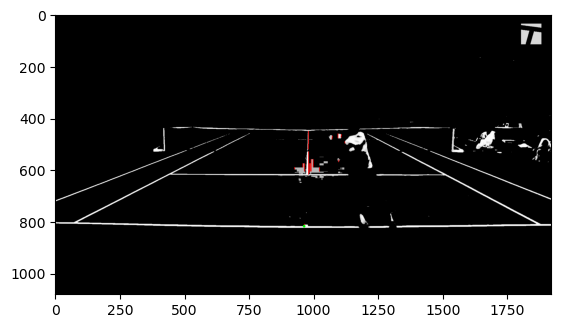

In [19]:
lsd = cv2.createLineSegmentDetector(cv2.LSD_REFINE_NONE)
lines = lsd.detect(gray)[0]
drawn_img = np.copy(gray)  # Copy the original image to draw on
drawn_img = cv2.cvtColor(drawn_img, cv2.COLOR_GRAY2BGR)  # Convert to color image to draw colored lines
candidates = vertical_lines_near_center(lines, gray.shape[1], gray.shape[0])

for line in candidates:
    x0, y0, x1, y1 = map(int, line[0])
    cv2.line(drawn_img, (x0, y0), (x1, y1), (255,0,0), 2)

lowest_y = 0
lowest_point = None
for line in candidates:
    x0, y0, x1, y1 = map(int, line[0])
    if (y0 > y1):
        if (y0 > lowest_y):
            lowest_y = y0
            lowest_point = (x0, y0)
    else:
        if (y1 > lowest_y):
            lowest_y = y1
            lowest_point = (x1, y1)

cv2.circle(drawn_img, lowest_point, radius=5, color=(0, 255, 0), thickness=-1)
plt.imshow(drawn_img)

In [20]:
lines[0]

array([[5.7225913e-01, 8.0890729e+02, 1.1756104e+03, 8.2778809e+02]],
      dtype=float32)

In [21]:
lsd_lines = []
lsd_horizontal_lines = []
lsd_vertical_lines = []
for line in lines:
    lsd_lines.append(to_rho_theta(line))

for rho, theta in lsd_lines:
    if theta < np.pi / 4 or theta > 3 * np.pi / 4:  # Vertical lines
        lsd_vertical_lines.append((rho, theta))
    elif np.pi / 4 <= theta <= 3 * np.pi / 4:  # Horizontal lines
        if np.pi/2 - 0.01 <= theta <= np.pi/2 + 0.01:
            lsd_horizontal_lines.append((rho, theta))

lsd_horizontal_lines.sort(key=lambda x: x[0])
lsd_vertical_lines.sort(key=lambda x: x[0])

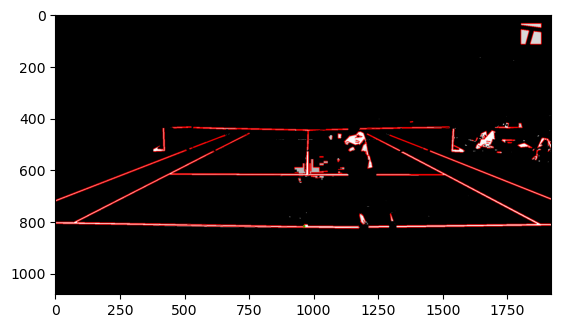

In [22]:
for line in lines:
    x0, y0, x1, y1 = map(int, line[0])
    cv2.line(drawn_img, (x0, y0), (x1, y1), (255,0,0), 2)

plt.imshow(drawn_img)

In [23]:
height, width = gray.shape
max_dim = max(height, width)

In [24]:
# Perform Canny edge detection
edges = cv2.Canny(img, 25, 100, apertureSize=3, L2gradient=True)

In [25]:
# Perform Hough Line Transform
lines = cv2.HoughLines(edges, 1, np.pi/180, 200)

In [26]:
horizontal_lines = []
vertical_lines = []

for rho, theta in lines[:, 0]:
    if theta < np.pi / 4 or theta > 3 * np.pi / 4:  # Vertical lines
        vertical_lines.append((rho, theta))
    elif np.pi / 4 <= theta <= 3 * np.pi / 4:  # Horizontal lines
        if np.pi/2 - 0.01 <= theta <= np.pi/2 + 0.01:
            horizontal_lines.append((rho, theta))

In [27]:
# Sort the lines by their rho value (distance from origin)
horizontal_lines.sort(key=lambda x: x[0])
vertical_lines.sort(key=lambda x: x[0])

In [28]:
horizontal_lines = merge_similar_lines(horizontal_lines, 5, 0.01)
vertical_lines = merge_similar_lines(vertical_lines, 20, 0.05)

In [29]:
intersections = find_intersections(horizontal_lines, vertical_lines)
intersections.sort(key=lambda y: y[1])

In [34]:
horizontal_lines

[[441.0, 1.5707963705062866],
 [445.0, 1.5707963705062866],
 [619.0, 1.5707963705062866],
 [813.0, 1.5707963705062866],
 [819.5, 1.5707963705062866],
 [824.0, 1.5707963705062866]]

In [30]:
hash = {}
for x, y in intersections:
    if y not in hash:
        hash[y] = [x]
    else:
        hash[y].append(x)

y_values = [y for y in hash]
y_values.sort()

h_trimmed = []
v_trimmed = []

for y in y_values:
    cv2.line(black, (min(hash[y]), y), (max(hash[y]), y), (0, 255, 0), 2)
    line = [[min(hash[y]), y], [max(hash[y]), y]]
    h_trimmed.append(line)


In [31]:
#Draw Remaining Four (or Less) Lines
top = y_values[0]
bottom = y_values[len(y_values) - 1]

cv2.line(black, (hash[top][0], top), (hash[bottom][0], bottom), (0, 255, 0), 2)
if [[hash[top][0], top], [hash[bottom][0], bottom]] not in v_trimmed:
    v_trimmed.append([[hash[top][0], top], [hash[bottom][0], bottom]])

cv2.line(black, (hash[top][1], top), (hash[bottom][1], bottom), (0, 255, 0), 2)
if [[hash[top][1], top], [hash[bottom][1], bottom]] not in v_trimmed:
    v_trimmed.append([[hash[top][1], top], [hash[bottom][1], bottom]])

cv2.line(black, (hash[top][len(hash[top]) - 2], top), (hash[bottom][len(hash[bottom]) - 2], bottom), (0, 255, 0), 2)
if [[hash[top][len(hash[top]) - 2], top], [hash[bottom][len(hash[bottom]) - 2], bottom]] not in v_trimmed:
    v_trimmed.append([[hash[top][len(hash[top]) - 2], top], [hash[bottom][len(hash[bottom]) - 2], bottom]])

cv2.line(black, (hash[top][len(hash[top]) - 1], top), (hash[bottom][len(hash[bottom]) - 1], bottom), (0, 255, 0), 2)
if [[hash[top][len(hash[top]) - 1], top], [hash[bottom][len(hash[bottom]) - 1], bottom]] not in v_trimmed:
    v_trimmed.append([[hash[top][len(hash[top]) - 1], top], [hash[bottom][len(hash[bottom]) - 1], bottom]])
x = 0

IndexError: list index out of range

In [32]:
for intersection in intersections:
    cv2.circle(black, intersection, 5, (255, 0, 0), -1)

In [31]:
known_line = [(lowest_point[1], np.pi/2)]
known_line


[(493, 1.5707963267948966)]

In [32]:
known_points = find_intersections(known_line, vertical_lines)
known_points

[(1175, 492), (239, 492), (353, 492)]

In [33]:
real_court = TennisCourtReference('court_reference_background\\blank_black.png')

In [39]:
matrix, score = search_for_court(known_points, horizontal_lines, vertical_lines, h_trimmed, v_trimmed, real_court)

In [40]:
matrix = np.round(matrix, 5)


In [42]:
inverse = np.linalg.inv(matrix)

img1 = cv2.imread('court_reference_background\\court_lines_green.png')
img2 = img
rows, cols, _ = img2.shape
new_img = cv2.warpPerspective(img1, inverse, (cols, rows))


In [673]:
if new_img.shape[2] == 3:
    b, g, r = cv2.split(new_img)
    alpha = np.ones(b.shape, dtype=b.dtype) * 255  # Fully opaque initially
    new_img = cv2.merge([b, g, r, alpha])

black_condition = (new_img[:, :, 0] == 0) & (new_img[:, :, 1] == 0) & (new_img[:, :, 2] == 0)

new_img[black_condition, 3] = 0

In [674]:
if img2.shape[2] == 3:
    b, g, r = cv2.split(img2)
    alpha = np.ones(b.shape, dtype=b.dtype) * 255  # Fully opaque initially
    img2 = cv2.merge([b, g, r, alpha])

In [675]:
background = img2
foreground = new_img

print(background.shape)
print(foreground.shape)

(720, 1280, 4)
(720, 1280, 4)


In [676]:
foreground_rgb = foreground[..., :4]
alpha_mask = foreground[..., 3]

if foreground.shape[:2] != background.shape[:2]:
    foreground_rgb = cv2.resize(foreground_rgb, (background.shape[1], background.shape[0]))

alpha_mask = alpha_mask / 255.0  
alpha_mask = alpha_mask[..., np.newaxis]  

composite_image = background * (1 - alpha_mask) + foreground_rgb * alpha_mask

composite_image = composite_image.astype(np.uint8)

In [677]:
cv2.imwrite('output_images\\' + 'test_image42.png', composite_image)

True

In [4]:
def find_intersections(horizontal_lines, vertical_lines):
    intersections = []
    for h_line in horizontal_lines:
        for v_line in vertical_lines:
            rho_h = h_line[0]
            theta_h = h_line[1]
            rho_v = v_line[0]
            theta_v = v_line[1]
            A = np.array([
                [np.cos(theta_h), np.sin(theta_h)],
                [np.cos(theta_v), np.sin(theta_v)]
            ])
            b = np.array([[rho_h], [rho_v]])
            intersection = np.linalg.solve(A, b)
            x, y = map(int, intersection)
            intersections.append((x, y))
    return intersections


In [5]:
def merge_similar_lines(lines, rho_d, theta_d):
    merged_lines = []

    while lines:
        base_line = lines.pop(0)
        rho_a, theta_a = base_line
        similar_lines = [base_line]
        
        lines_to_remove = []

        for line in lines:
            rho_b, theta_b = line
            if abs(rho_a - rho_b) <= rho_d and abs(theta_a - theta_b) <= theta_d:
                similar_lines.append(line)
                lines_to_remove.append(line)

        for line in lines_to_remove:
            lines.remove(line)

        rho_cumulative = sum(line[0] for line in similar_lines)
        theta_cumulative = sum(line[1] for line in similar_lines)
        rho_average = rho_cumulative / len(similar_lines)
        theta_average = theta_cumulative / len(similar_lines)

        merged_lines.append([rho_average, theta_average])

    return merged_lines

In [6]:
class TennisCourtReference():
    def __init__(self, blank_image_path):
        self.point1 = (0 + 60, 0 + 60)
        self.point2 = (45 + 60, 0 + 60)
        self.point3 = (315 + 60, 0 + 60)
        self.point4 = (360 + 60, 0 + 60)
        self.point5 = (0 + 60, 180 + 60)
        self.point6 = (45 + 60, 180 + 60)
        self.point7 = (180 + 60, 180 + 60)
        self.point8 = (315 + 60, 180 + 60)
        self.point9 = (360 + 60, 180 + 60)
        self.point10 = (0 + 60, 600 + 60)
        self.point11 = (45 + 60, 600 + 60)
        self.point12 = (180 + 60, 600 + 60)
        self.point13 = (315 + 60, 600 + 60)
        self.point14 = (360 + 60, 600 + 60)
        self.point15 = (0 + 60, 780 + 60)
        self.point16 = (45 + 60, 780 + 60)
        self.point17 = (315 + 60, 780 + 60)
        self.point18 = (360 + 60, 780 + 60)
        self.horizontal_lines = (((self.point1), (self.point4)), 
                                 ((self.point5), (self.point9)), 
                                 ((self.point10), (self.point14)), 
                                 ((self.point15), (self.point18)))
        self.vertical_lines = (((self.point1), (self.point15)), 
                               ((self.point2), (self.point16)), 
                               ((self.point3), (self.point17)), 
                               ((self.point4), (self.point18)))
        self.blank_image = cv2.imread(blank_image_path)
    def draw_lines(self, thickness, circles=False, color=(255, 255, 255)):
        img = self.blank_image
        cv2.line(img, (self.point1), (self.point4), color, thickness)
        cv2.line(img, (self.point5), (self.point9), color, thickness)
        cv2.line(img, (self.point10), (self.point14), color, thickness)
        cv2.line(img, (self.point15), (self.point18), color, thickness)
        cv2.line(img, (self.point1), (self.point15) , color, thickness)
        cv2.line(img, (self.point2), (self.point16) , color, thickness)
        cv2.line(img, (self.point7), (self.point12) , color, thickness)
        cv2.line(img, (self.point3), (self.point17) , color, thickness)
        cv2.line(img, (self.point4), (self.point18) , color, thickness)
        if circles:
            cv2.circle(img, self.point1, 5, (255, 0, 0), -1)
            cv2.circle(img, self.point2, 5, (255, 0, 0), -1)
            cv2.circle(img, self.point3, 5, (255, 0, 0), -1)
            cv2.circle(img, self.point4, 5, (255, 0, 0), -1)
            cv2.circle(img, self.point5, 5, (255, 0, 0), -1)
            cv2.circle(img, self.point6, 5, (255, 0, 0), -1)
            cv2.circle(img, self.point7, 5, (255, 0, 0), -1)
            cv2.circle(img, self.point8, 5, (255, 0, 0), -1)
            cv2.circle(img, self.point9, 5, (255, 0, 0), -1)
            cv2.circle(img, self.point10, 5, (255, 0, 0), -1)
            cv2.circle(img, self.point11, 5, (255, 0, 0), -1)
            cv2.circle(img, self.point12, 5, (255, 0, 0), -1)
            cv2.circle(img, self.point13, 5, (255, 0, 0), -1)
            cv2.circle(img, self.point14, 5, (255, 0, 0), -1)
            cv2.circle(img, self.point15, 5, (255, 0, 0), -1)
            cv2.circle(img, self.point16, 5, (255, 0, 0), -1)
            cv2.circle(img, self.point17, 5, (255, 0, 0), -1)
            cv2.circle(img, self.point18, 5, (255, 0, 0), -1)
        return img

In [7]:
def search_for_court(known_points, horizontal_lines, vertical_lines, h_trimmed, v_trimmed, tennis_court):
    best_score = 0
    best_matrices = []
    best_matrix = None
    thres = 10
    if len(horizontal_lines) < 2 or len(vertical_lines) < 2:
        return None
    for i in range(len(vertical_lines)): #4
        v_line_1 = vertical_lines[i]
        for j in range(i + 1, len(vertical_lines)): #3
            v_line_2 = vertical_lines[j]
            for k in range(len(horizontal_lines)): #4
                h_line_1 = horizontal_lines[k]
                for l in range (k + 1, len(horizontal_lines)): #3
                    h_line_2 = horizontal_lines[l]
                    #Find Intersections
                    h_lines = [h_line_1, h_line_2]
                    v_lines = [v_line_1, v_line_2]
                    intersections = find_intersections(h_lines, v_lines) #2 * 2 = 4
                    #Hash X at each Y level
                    hash_map = hash_coordinates(intersections)
                    top_left, top_right, bottom_left, bottom_right = construct_points(hash_map) #PROCESSED IMAGE KEY POINTS
                    pts1 = np.array([np.array(top_left), np.array(top_right), np.array(bottom_left), np.array(bottom_right)], dtype=np.float32)
                    #Establish Horizontal Lines
                    horizontal_rl = tennis_court.horizontal_lines
                    if v_line_1[1] > np.pi/2 and v_line_2[1] > np.pi/2:
                        #Search Right Side 6 Boxes
                        vertical_rl = (tennis_court.vertical_lines[2], tennis_court.vertical_lines[3])
                        for m in range(len(horizontal_rl)):
                            r_h_line_1 = horizontal_rl[m]
                            for n in range(m + 1, len(horizontal_rl)):
                                r_h_line_2 = horizontal_rl[n]
                                r_h_lines = [r_h_line_1, r_h_line_2]
                                r_v_lines = [vertical_rl[0], vertical_rl[1]]
                                r_intersections = find_intersections_x_y(r_h_lines, r_v_lines)
                                r_hash_map = hash_coordinates(r_intersections)
                                r_top_left, r_top_right, r_bottom_left, r_bottom_right = construct_points(r_hash_map) #REAL TENNIS COURT KEY POINTS
                                pts2 = np.array([np.array(r_top_left), np.array(r_top_right), np.array(r_bottom_left), np.array(r_bottom_right)], dtype=np.float32)
                                M = cv2.getPerspectiveTransform(pts1, pts2)
                                #Project Each Line with M
                                transformed_h_lines = map_lines(M, h_trimmed)
                                transformed_v_lines = map_lines(M, v_trimmed)
                                #Function to Count Hits and Misses
                                h_overlaps = min(horizontal_overlaps(tennis_court.horizontal_lines, transformed_h_lines, thres-2), 4)
                                v_overlaps = min(vertical_overlaps(tennis_court.vertical_lines, transformed_v_lines, thres), 4)
                                score = h_overlaps + v_overlaps
                                if score == 8:
                                    return M, score
                                elif score > best_score:
                                    best_score = score #THIS WAS NOT HERE
                                    best_matrices.clear()
                                    best_matrices.append(M)
                                elif score == best_score:
                                    best_matrices.append(M)
                    elif v_line_1[1] < np.pi/2 and v_line_2[1] < np.pi/2:
                        #Search Left Side 6 Boxes
                        vertical_rl = (tennis_court.vertical_lines[0], tennis_court.vertical_lines[1])
                        for m in range(len(horizontal_rl)):
                            r_h_line_1 = horizontal_rl[m]
                            for n in range(m + 1, len(horizontal_rl)):
                                r_h_line_2 = horizontal_rl[n]
                                r_h_lines = [r_h_line_1, r_h_line_2]
                                r_v_lines = [vertical_rl[0], vertical_rl[1]]
                                r_intersections = find_intersections_x_y(r_h_lines, r_v_lines)
                                r_hash_map = hash_coordinates(r_intersections)
                                r_top_left, r_top_right, r_bottom_left, r_bottom_right = construct_points(r_hash_map) #REAL TENNIS COURT KEY POINTS
                                pts2 = np.array([np.array(r_top_left), np.array(r_top_right), np.array(r_bottom_left), np.array(r_bottom_right)], dtype=np.float32)
                                M = cv2.getPerspectiveTransform(pts1, pts2)
                                #Project Each Line with M
                                transformed_h_lines = map_lines(M, h_trimmed)
                                transformed_v_lines = map_lines(M, v_trimmed)
                                #Function to Count Hits and Misses
                                h_overlaps = min(horizontal_overlaps(tennis_court.horizontal_lines, transformed_h_lines, thres), 4)
                                v_overlaps = min(vertical_overlaps(tennis_court.vertical_lines, transformed_v_lines, thres), 4)
                                score = h_overlaps + v_overlaps
                                if score == 8:
                                    return M, score
                                elif score > best_score:
                                    best_score = score #THIS WAS NOT HERE
                                    best_matrices.clear()
                                    best_matrices.append(M)
                                elif score == best_score:
                                    best_matrices.append(M)
                    else:
                        #Search other 24 Boxes
                        vertical_rl_left = (tennis_court.vertical_lines[0], tennis_court.vertical_lines[1])
                        vertical_rl_right = (tennis_court.vertical_lines[2], tennis_court.vertical_lines[3])
                        for a in range(len(vertical_rl_left)):
                            left_line = vertical_rl_left[a]
                            for b in range (len(vertical_rl_right)):
                                right_line = vertical_rl_right[b]
                                for m in range(len(horizontal_rl)):
                                    r_h_line_1 = horizontal_rl[m]
                                    for n in range(m + 1, len(horizontal_rl)):
                                        r_h_line_2 = horizontal_rl[n]
                                        r_h_lines = [r_h_line_1, r_h_line_2]
                                        r_v_lines = [left_line, right_line]
                                        r_intersections = find_intersections_x_y(r_h_lines, r_v_lines)
                                        r_hash_map = hash_coordinates(r_intersections)
                                        r_top_left, r_top_right, r_bottom_left, r_bottom_right = construct_points(r_hash_map) #REAL TENNIS COURT KEY POINTS
                                        pts2 = np.array([np.array(r_top_left), np.array(r_top_right), np.array(r_bottom_left), np.array(r_bottom_right)], dtype=np.float32)
                                        M = cv2.getPerspectiveTransform(pts1, pts2)
                                        #Project Each Line with M
                                        transformed_h_lines = map_lines(M, h_trimmed)
                                        transformed_v_lines = map_lines(M, v_trimmed)
                                        #Function to Count Hits and Misses
                                        h_overlaps = min(horizontal_overlaps(tennis_court.horizontal_lines, transformed_h_lines, thres), 4)
                                        v_overlaps = min(vertical_overlaps(tennis_court.vertical_lines, transformed_v_lines, thres), 4)
                                        score = min(h_overlaps + v_overlaps, len(horizontal_lines) + len(vertical_lines))
                                        if score == 8:
                                            return M, score
                                        elif score > best_score:
                                            best_score = score #THIS WAS NOT HERE
                                            best_matrices.clear()
                                            best_matrices.append(M)
                                        elif score == best_score:
                                            best_matrices.append(M)
    #Tiebreaker Part 1
    filtered = []
    for matrix in best_matrices:
        counter = 0 
        inverse_matrix = np.linalg.inv(matrix)
        compare_array = [transform_point(real_court.point10, inverse_matrix), transform_point(real_court.point11, inverse_matrix), transform_point(real_court.point13, inverse_matrix), transform_point(real_court.point14, inverse_matrix)]
        for point in known_points:
            for c_point in compare_array:
                if np.linalg.norm(point - c_point) <= 10:
                    counter += 1
        if (counter == len(known_points)):
            filtered.append(matrix)
    closest = np.inf
    real_point = real_court.point12
    if len(filtered) != 0:
        for matrix in filtered:
            hypothetical_point = matrix @ np.array([[lowest_point[0]], [lowest_point[1]], [1]], dtype=np.float32)
            t_hypothetical_point = hypothetical_point[:2, 0] / hypothetical_point[2, 0]
            distance = np.linalg.norm(t_hypothetical_point - real_point)
            if distance < closest:
                closest = distance
                best_matrix = matrix 
    else:
        for matrix in best_matrices:
            hypothetical_point = matrix @ np.array([[lowest_point[0]], [lowest_point[1]], [1]], dtype=np.float32)
            t_hypothetical_point = hypothetical_point[:2, 0] / hypothetical_point[2, 0]
            distance = np.linalg.norm(t_hypothetical_point - real_point)
            if distance < closest:
                closest = distance
                best_matrix = matrix 
    
    return best_matrix, best_score

In [8]:
def hash_coordinates(array):
    hash = {}
    for x, y in array:
        if y not in hash:
            hash[y] = [x]
        else:
            hash[y].append(x)
    return hash

In [9]:
def construct_points(hash):
    top_line = min(hash.keys())
    bottom_line = max(hash.keys())
    top_left = (min(hash[top_line]), top_line)
    top_right = (max(hash[top_line]), top_line)
    bottom_left = (min(hash[bottom_line]), bottom_line)
    bottom_right = (max(hash[bottom_line]), bottom_line)
    return top_left, top_right, bottom_left, bottom_right

In [10]:
def map_lines(M, lines):
    transformed_lines = []
    
    for line in lines:
        pt1 = np.array([[line[0][0]], [line[0][1]], [1]], dtype=np.float32)
        pt2 = np.array([[line[1][0]], [line[1][1]], [1]], dtype=np.float32)

        # Transform points using the matrix M
        transformed_pt1_homogeneous = M @ pt1
        transformed_pt2_homogeneous = M @ pt2
        
        # Convert points back to Cartesian coordinates
        transformed_pt1 = transformed_pt1_homogeneous[:2] / transformed_pt1_homogeneous[2]
        transformed_pt2 = transformed_pt2_homogeneous[:2] / transformed_pt2_homogeneous[2]
        
        # Append transformed line endpoints to the list
        transformed_lines.append((transformed_pt1, transformed_pt2))
    
    # Convert list of tuples to numpy array
    transformed_lines = np.array(transformed_lines, dtype=np.float32)
    
    return transformed_lines

In [11]:
def horizontal_overlaps(court_horizontal, reference_horizontal, threshold):
    overlaps = 0
    for ch in court_horizontal:
        _, y = ch[0]
        for rh in reference_horizontal:
            _, r_y = rh[0]
            if (abs(y - r_y) < threshold):
                overlaps += 1
                break
    return overlaps

In [12]:
def vertical_overlaps(court_vertical, reference_vertical, threshold):
    overlaps = 0
    for ch in court_vertical:
        x, _ = ch[0]
        for rh in reference_vertical:
            r_x, _ = rh[0]
            if (abs(x - r_x) < threshold):
                overlaps += 1
    return overlaps

In [13]:
def find_intersections_x_y(horizontal_lines, vertical_lines):
    intersections = []
    for h in horizontal_lines:
        y = h[0][1]
        for v in vertical_lines:
            x = v[0][0]
            intersection = [x, y]
            intersections.append(intersection)
    return intersections

In [14]:
def make_transparent(new_img):
    if new_img.shape[2] == 3:
        b, g, r = cv2.split(new_img)
        alpha = np.ones(b.shape, dtype=b.dtype) * 255  # Fully opaque initially
        new_img = cv2.merge([b, g, r, alpha])

    black_condition = (new_img[:, :, 0] == 0) & (new_img[:, :, 1] == 0) & (new_img[:, :, 2] == 0)

    new_img[black_condition, 3] = 0

In [15]:
# Function to check if a line is vertical
def is_vertical(line, threshold=2):
    x1, y1, x2, y2 = line[0]
    return abs(x1 - x2) < threshold

# Function to find vertical lines near the center of the image
def vertical_lines_near_center(lines, image_width, image_height, h_margin=0.1, v_margin=0.3):
    vertical_lines_near_center = []

    center_x = image_width / 2
    margin_x = image_width * h_margin

    center_y = image_height / 2
    margin_y = image_height * v_margin

    # Define the center region
    center_left = center_x - margin_x
    center_right = center_x + margin_x

    center_top = center_y - margin_y
    center_bottom = center_y + margin_y

    # Filter lines to find vertical lines near the center
    for line in lines:
        if is_vertical(line) and (center_left <= line[0][0] <= center_right) and (center_top <= line[0][1] <= center_bottom and center_top <= line[0][3] <= center_bottom):
            vertical_lines_near_center.append(line)

    return vertical_lines_near_center

In [16]:
def transform_point(point, matrix):
    t_point = matrix @ np.array([[point[0]], [point[1]], [1]], dtype=np.float32)
    b_point = t_point[:2, 0] / t_point[2, 0]
    return b_point

In [17]:
def to_rho_theta(line):
    x1, y1, x2, y2 = line[0]

    dx = x2 - x1
    dy = y2 - y1

    # Calculate theta
    theta = np.arctan2(dy, dx)

    # Calculate rho
    rho = (x1 * y2 - y1 * x2) / np.sqrt(dx**2 + dy**2)
    
    # Ensure rho is positive
    if rho < 0:
        rho = -rho
        theta += np.pi

    return [rho, theta]